<a href="https://colab.research.google.com/github/nsoria1/covid19-chestxray-analysis/blob/master/covid19_chestrayx_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Instalación de dependencias & bajada de datasets

Instalar librerias utilizadas

In [0]:
!pip install imutils

Crear carpetas donde alojar los key para la API de Kaggle

In [0]:
!rm /root/.kaggle && mkdir /root/.kaggle
!echo '{"username":"nicolassoria","key":"4e554baab00edaf0d56fb1d4990269ed"}' > /root/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': Is a directory
rm: cannot remove 'chest-xray-pneumonia.zip': No such file or directory


Borrar los archivos de Kaggle si existieran

In [0]:
!rm chest-xray-pneumonia.zip && rm covid-chest-xray.zip

rm: cannot remove 'chest-xray-pneumonia.zip': No such file or directory


Descargar datasets Rayos X normales y de Neumonia y Rayos X de Covid 19

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d bachrr/covid-chest-xray

100% 2.29G/2.29G [00:19<00:00, 46.2MB/s]
100% 2.29G/2.29G [00:19<00:00, 127MB/s] 
 93% 196M/211M [00:05<00:02, 6.64MB/s]
100% 211M/211M [00:05<00:00, 40.0MB/s]


Crear directorios para alojar data

In [0]:
!rm -r covid-chest-xray chest-xray-pneumonia
!mkdir chest-xray-pneumonia && mkdir covid-chest-xray

rm: cannot remove 'covid-chest-xray': No such file or directory
rm: cannot remove 'chest-xray-pneumonia': No such file or directory


Descomprimir archivos en carpetas creadas

In [0]:
!unzip -qq chest-xray-pneumonia.zip -d chest-xray-pneumonia/ && rm chest-xray-pneumonia.zip && unzip -qq covid-chest-xray.zip -d covid-chest-xray/ && rm covid-chest-xray.zip

Validar carpetas creadas y archivos borrados

In [0]:
!ls -l

total 12
drwxr-xr-x 3 root root 4096 May  4 22:33 chest-xray-pneumonia
drwxr-xr-x 4 root root 4096 May  4 22:33 covid-chest-xray
drwxr-xr-x 1 root root 4096 Apr  3 16:24 sample_data


### Importar librerias requeridas para procesamiento

In [0]:
# Standart libraries
import shutil
import cv2
import os
import random
# Import data handling libraries
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# Import scikit-learn libraries
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Import Tensorflow / Keras libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

Definir área de trabajo

In [0]:
!rm -rf dataset
!mkdir -p dataset/covid
!mkdir -p dataset/normal

In [0]:
dataset_path = '/content/dataset'
covid_dataset_path = '/content/covid-chest-xray'
pneumonia_dataset_path ='/content/chest-xray-pneumonia/chest_xray'

### Construcción de set de datos


Construir set de datos de rayos X con Covid 19

In [0]:
samples = 25

Recorrer el archivo *metadata.csv*, cuyo campo *finding* menciona si tiene COVID-19 o no, y en caso positivo mover a carpeta dataset/covid

In [0]:
# construct the path to the metadata CSV file and load it
csvPath = os.path.sep.join([covid_dataset_path, "metadata.csv"])
df = pd.read_csv(csvPath)

# loop over the rows of the COVID-19 data frame
for (i, row) in df.iterrows():
    # if (1) the current case is not COVID-19 or (2) this is not
    # a 'PA' view, then ignore the row
    if row["finding"] != "COVID-19" or row["view"] != "PA":
        continue

    # build the path to the input image file
    imagePath = os.path.sep.join([covid_dataset_path, "images", row["filename"]])

    # if the input image file does not exist (there are some errors in
    # the COVID-19 metadeta file), ignore the row
    if not os.path.exists(imagePath):
        continue

    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = row["filename"].split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/covid", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

Construir set de datos de rayos X normales

In [0]:
basePath = os.path.sep.join([pneumonia_dataset_path, "train", "NORMAL"])
imagePaths = list(paths.list_images(basePath))

# randomly sample the image paths
random.seed(42)
random.shuffle(imagePaths)
imagePaths = imagePaths[:samples]

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    # extract the filename from the image path and then construct the
    # path to the copied image file
    filename = imagePath.split(os.path.sep)[-1]
    outputPath = os.path.sep.join([f"{dataset_path}/normal", filename])

    # copy the image
    shutil.copy2(imagePath, outputPath)

### Realizar plots de los rayos X

Función de apoyo para realizar un plot de los rayos X

In [0]:
def ceildiv(a, b):
    return -(-a // b)

def plots_from_files(imspaths, figsize=(10,5), rows=1, titles=None, maintitle=None):
    """Plot the images in a grid"""
    f = plt.figure(figsize=figsize)
    if maintitle is not None: plt.suptitle(maintitle, fontsize=10)
    for i in range(len(imspaths)):
        sp = f.add_subplot(rows, ceildiv(len(imspaths), rows), i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        img = plt.imread(imspaths[i])
        plt.imshow(img)

Plot de los rayos X

In [0]:
normal_images = list(paths.list_images(f"{dataset_path}/normal"))
covid_images = list(paths.list_images(f"{dataset_path}/covid"))

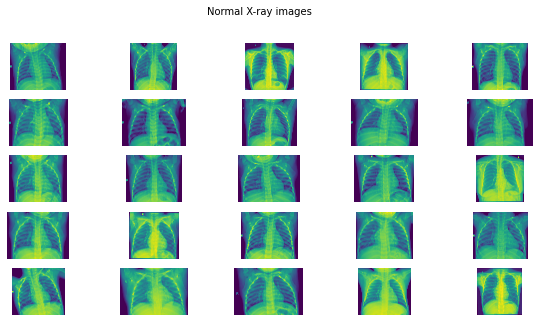

In [0]:
plots_from_files(normal_images, rows=5, maintitle="Normal X-ray images")

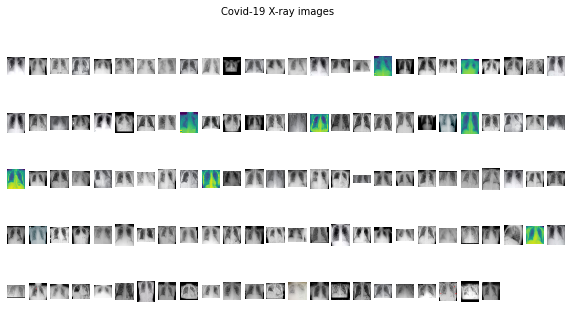

In [0]:
plots_from_files(covid_images, rows=5, maintitle="Covid-19 X-ray images")

### Pre-procesamiento de datos

In [0]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 10
BS = 8



*   Cargar en una lista los path de las imagenes
*   Se recorre la lista 





In [0]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    # load the image, swap color channels, and resize it to be a fixed
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 1]
data = np.array(data) / 255.0
labels = np.array(labels)

[INFO] loading images...
['/content/dataset/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4b.png', '/content/dataset/covid/53EC07C9-5CC6-4BE4-9B6F-D7B0D72AAA7E.jpeg', '/content/dataset/covid/nCoV-radiol.2020200269.fig1-day7.jpeg', '/content/dataset/covid/auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', '/content/dataset/covid/85E52EB3-56E9-4D67-82DA-DEA247C82886.jpeg', '/content/dataset/covid/covid-19-pneumonia-20.jpg', '/content/dataset/covid/2966893D-5DDF-4B68-9E2B-4979D5956C8E.jpeg', '/content/dataset/covid/16660_1_1.jpg', '/content/dataset/covid/nejmoa2001191_f4.jpeg', '/content/dataset/covid/B2D20576-00B7-4519-A415-72DE29C90C34.jpeg', '/content/dataset/covid/covid-19-pneumonia-8.jpg', '/content/dataset/covid/nejmoa2001191_f3-PA.jpeg', '/content/dataset/covid/1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg', '/content/dataset/covid/covid-19-pneumonia-28.png', '/content/dataset/covid/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3b.png', '/con

In [0]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)
# initialize the training data augmentation object
trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

### Creación de Modelo

In [0]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False